# 23. Proxy evidence for oxygen variability in the Natal Valley
Here we use authigenic uranium data from [Bard and Rickaby (2009) "Migration of the subtropical front as a modulator of glacial climate"](https://www.nature.com/articles/nature08189) as a proxy for bottom water oxygen to connect long term trends in bottom water oxygen to long term trends in green band formation.

## Setup
### Import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.ticker import AutoMinorLocator
from scipy import signal,interpolate,stats,linalg
from IPython.display import clear_output
import time
import numpy as np
import seaborn as sns
%matplotlib inline
from matplotlib.patches import Patch

### Set paths

In [2]:
data_path='/Users/danielbabin/GitHub/Green_Bands/Data/'
table_path='/Users/danielbabin/GitHub/Green_Bands/Tables/'
core_photos='/Users/danielbabin/GitHub/Green_Bands/CorePhotos/LowRes/'
figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Main/'
sup_figure_path='/Users/danielbabin/GitHub/Green_Bands/Figures/Supplementary/'
misc_path='/Users/danielbabin/GitHub/Green_Bands/Data/Misc/'
checkpoints_path='/Users/danielbabin/GitHub/Green_Bands/Data/Checkpoints/'

### Import data
#### Glacials

In [3]:
glacials=[[14, 29],[57, 71],[130, 191],[243, 300],[337, 374],[424, 478],[524, 563],[621, 676],
          [712, 761],[790, 814],[866, 900],[917, 936],[959, 970],[982, 1014],[1031, 1062],[1081,1104],
          [1114, 1141],[1190,1215],[1240,1265],[1285,1300]]
terminations=[[14,20],[130,140],[243,253],[337,347],[424,432],[529,535],[622,632]]

#### Green bands

In [4]:
green_layers_U1474=pd.read_csv(table_path+'Supplementary Table 6A - U1474 green bands.csv')
green_layers_1313=pd.read_csv(table_path+'Supplementary Table 6B - U1313 green bands.csv')

In [5]:
submission_path='/Users/danielbabin/GitHub/Natal_Valley_Green_Layers/Manuscript/Initial Submission/'

In [6]:
green_true_U1474=green_layers_U1474.copy()

green_layers_1313['Class']=green_layers_1313['Label']-1
green_true_1313=green_layers_1313[green_layers_1313['Class']>0].copy()

In [7]:
amU1474=pd.read_csv(table_path+'Supplementary Table 2 - Age-depth model.csv')
amU1474['Top Interval Depth CCSF (m)']=amU1474['Depth CCSF (m)'].shift(1)
amU1474['Top Interval Age (kyr)']=amU1474['Age (kyr)'].shift(1)
famU1474=interpolate.interp1d(amU1474['Depth CCSF (m)'],amU1474['Age (kyr)'],bounds_error=False)

In [8]:
am1313=pd.read_csv(misc_path+'1313_age_model_L*.csv')
fam1313=interpolate.interp1d(am1313['Depth (mcd)'],am1313['Age (ka)'],bounds_error=False)

In [9]:
green_true_U1474['Top Age (kyr)']=famU1474(green_true_U1474['Top Depth CCSF (m)'])
green_true_U1474['Bottom Age (kyr)']=famU1474(green_true_U1474['Bottom Depth CCSF (m)'])
agtU1474=green_true_U1474[~green_true_U1474['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

In [10]:
green_true_1313['Top Age (kyr)']=fam1313(green_true_1313['Top Depth CCSF (m)'])
green_true_1313['Bottom Age (kyr)']=fam1313(green_true_1313['Bottom Depth CCSF (m)'])
agt1313=green_true_1313[~green_true_1313['Top Age (kyr)'].isnull()].set_index('Top Age (kyr)').sort_index()

## N events per stage
To get a kind of running average of both green band formation and the bottom water oxygen proxy, authigenic uranium, we calculate
1. Number of green band events per marine isotope stage
2. The average concentration of authigenic uranium in sediment

for each marine isotope stage

### Import depth boundaries for isotope stages at U1474

In [11]:
depths_MIS=pd.read_csv(checkpoints_path+'U1474 Marine Isotope Stage Depths.csv',index_col='MIS')

In [12]:
depths_MIS_no234=depths_MIS.copy()

### Combine 2, 3 and 4
MIS 3 is not a real interglacial y'all

In [13]:
depths_MIS_no234.loc[2,['Bottom Depth (m)','Bottom Age (kyr)']]=depths_MIS_no234.loc[5,['Top Depth (m)',
                                                                                        'Top Age (kyr)']].values
depths_MIS_no234=depths_MIS_no234.drop([3,4])

In [14]:
depths_MIS_no234.loc[2,'Duration (kyr)']=(depths_MIS_no234.loc[2,'Bottom Age (kyr)']-
                                          depths_MIS_no234.loc[2,'Top Age (kyr)'])
depths_MIS_no234.loc[2,'Thickness (cm)']=(depths_MIS_no234.loc[2,'Bottom Depth (m)']-
                                          depths_MIS_no234.loc[2,'Top Depth (m)'])*100
depths_MIS_no234.loc[2,'Sedimentation Rate (cm/kyr)']=(depths_MIS_no234.loc[2,'Thickness (cm)']/
                                                       depths_MIS_no234.loc[2,'Duration (kyr)'])

### Green banding counts

In [15]:
green_per=pd.DataFrame(index=depths_MIS_no234.index)

for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=agtU1474.loc[end:start]
    
    ### thickness and numbers
    green_per.loc[mis,'U1474 n']=slc.shape[0]
    green_per.loc[mis,'U1474 n/kyr']=(green_per.loc[mis,'U1474 n']/duration)
    green_per.loc[mis,'U1474 Thickness']=slc['Thickness (cm)'].sum()
    green_per.loc[mis,'U1474 Thickness/kyr']=green_per.loc[mis,'U1474 Thickness']/duration

for i,mis in enumerate(depths_MIS_no234.index):
    start=depths_MIS_no234.loc[mis,'Bottom Age (kyr)']
    end=depths_MIS_no234.loc[mis,'Top Age (kyr)']
    duration=depths_MIS_no234.loc[mis,'Duration (kyr)']
    
    slc=agt1313.loc[end:start]
    
    ### thickness and numbers
    green_per.loc[mis,'1313 n']=slc.shape[0]
    green_per.loc[mis,'1313 n/kyr']=(green_per.loc[mis,'1313 n']/duration)
    # green_per.loc[mis,'Thickness (cm)']=slc['thickness'].sum()
    green_per.loc[mis,'1313 Thickness']=slc['Thickness (cm)'].sum()
    green_per.loc[mis,'1313 Thickness/kyr']=green_per.loc[mis,'1313 Thickness']/duration

green_per['both n']=green_per['U1474 n']+green_per['1313 n']
green_per['both n/kyr']=green_per['U1474 n/kyr']+green_per['1313 n/kyr']
green_per['both Thickness']=green_per['U1474 Thickness']+green_per['1313 Thickness']
green_per['both Thickness/kyr']=green_per['U1474 Thickness/kyr']+green_per['1313 Thickness/kyr']

### Ages
col_list=['Top Age (kyr)','Bottom Age (kyr)','Duration (kyr)']
green_per[col_list]=depths_MIS_no234[col_list]

### Authigenic Uranium averages

In [16]:
bard=pd.read_csv(misc_path+'MD96-2077_proxy_data.csv',index_col='Age (kyr) EB-FR 17/0/07')

In [17]:
bard_GIG=pd.DataFrame(columns=['mean U auth','mean TOC','std TOC','sed rate','density'])

In [18]:
bard['depth m']=bard['depth cm']/100

In [19]:
am_bard=interpolate.interp1d(bard['depth m'],bard.index,bounds_error=False)

In [20]:
pp=pd.read_csv(misc_path+'MD96-2077_physical_properties.tab',sep='\t',header=15)
pp['Age (kyr)']=am_bard(pp['Depth [m]'])
pp=pp[~pp['Age (kyr)'].isnull()]
app=pp.set_index('Age (kyr)')

In [21]:
for i in depths_MIS.index:
    top_age=depths_MIS.loc[i,'Top Age (kyr)']
    bot_age=depths_MIS.loc[i,'Bottom Age (kyr)']
    top_depth=bard.loc[top_age:bot_age,'depth cm'].min()
    bot_depth=bard.loc[top_age:bot_age,'depth cm'].max()
    thickness=bot_depth-top_depth
    duration=bot_age-top_age
    bard_GIG.loc[i,'mean U auth']=bard.loc[top_age:bot_age,'Uauth ppm cfb'].mean()
#     bard_GIG.loc[i,'std U auth']=bard.loc[top_age:bot_age,'Uauth ppm cfb'].std()
    bard_GIG.loc[i,'mean TOC']=bard.loc[top_age:bot_age,'%TOC'].mean()
    bard_GIG.loc[i,'std TOC']=bard.loc[top_age:bot_age,'%TOC'].std()
    bard_GIG.loc[i,'sed rate']=thickness/duration
    bard_GIG.loc[i,'density']=app.loc[top_age:bot_age,'WBD [g/cm**3]'].mean()
bard_GIG.loc[1,'density']=bard_GIG.loc[2,'density']
bard_GIG.loc[20,'std TOC']=0
bard_GIG=bard_GIG.dropna().copy()

col_list=['Top Age (kyr)','Bottom Age (kyr)','Duration (kyr)']
bard_GIG[col_list]=depths_MIS_no234[col_list]

## Make figure

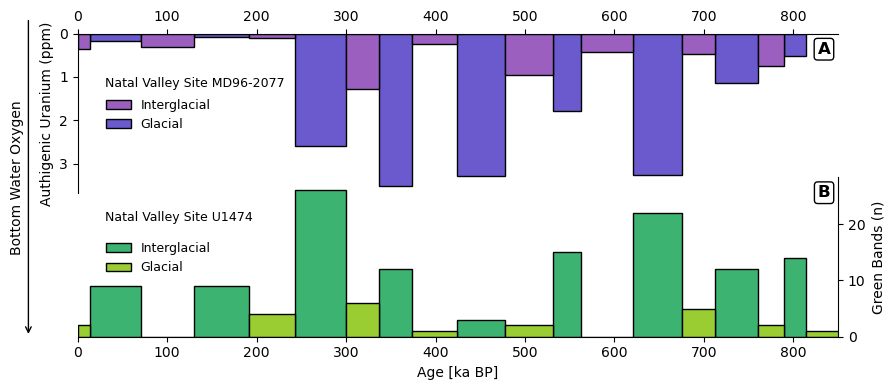

In [22]:
fig,axes=plt.subplots(nrows=2,sharex=True,figsize=(9,4))

sns.despine(ax=axes[0],bottom=True,top=False,right=True)
sns.despine(ax=axes[1],bottom=False,top=True,right=False,left=True)

for ax in axes:
    ax.patch.set_visible(False)
for ax in [axes[1]]:
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position('right')

ax=axes[0]
gsed=bard_GIG[bard_GIG.index%2==0]
igsed=bard_GIG[bard_GIG.index%2==1]

col='mean U auth'
# col='n/per kyr'
# col='Thickness (cm)'
# col='Thickness per kyr'
ax.bar(gsed['Top Age (kyr)'],gsed[col],gsed['Duration (kyr)'],
       align='edge',label='Glacial',alpha=1,color='#6A5ACD',ec='k')
ax.bar(igsed['Top Age (kyr)'],igsed[col],igsed['Duration (kyr)'],
       align='edge',label='Interglacial',alpha=1,color='#9B5FC0',ec='k')
ax.invert_yaxis()

# ax.scatter(bard['Uauth ppm cfb'].index,bard['Uauth ppm cfb'].values,color='k',alpha=.2,s=3)

custom_lines = [Patch(color='#9B5FC0', ec='k'),
                Patch(color='#6A5ACD', ec='k')]
legend=ax.legend(custom_lines, ['Interglacial','Glacial'],loc=(.03,.36),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
ax.annotate('Natal Valley Site MD96-2077',xy=(30,1.3),xycoords='data',va='bottom',ha='left',fontsize=9)

# ax.set_ylim(6,0)
ax.set_ylabel('Authigenic Uranium (ppm)')

ax=axes[1]
gsed=green_per[green_per.index%2==0]
igsed=green_per[green_per.index%2==1]

col='U1474 n'
# col='n/per kyr'
# col='Thickness (cm)'
# col='Thickness per kyr'
ax.bar(gsed['Top Age (kyr)'],gsed[col],gsed['Duration (kyr)'],
       align='edge',label='Glacial',alpha=1,color='#3CB371',ec='k')
ax.bar(igsed['Top Age (kyr)'],igsed[col],igsed['Duration (kyr)'],
       align='edge',label='Interglacial',alpha=1,color='#9ACD32',ec='k')

ax.set_ylabel('Green Bands (n)')

custom_lines = [Patch(color='#3CB371', ec='k'),
                Patch(color='#9ACD32', ec='k')]
legend=ax.legend(custom_lines, ['Interglacial','Glacial'],loc=(.03,.36),
          edgecolor='None', fontsize=9)
legend.get_frame().set_alpha(None)
legend.get_frame().set_facecolor((0, 0, 0, 0))
ax.annotate('Natal Valley Site U1474',xy=(30,20),xycoords='data',va='bottom',ha='left',fontsize=9)

ax.set_xlim(0,850)
ax.set_xlabel('Age [ka BP]')

ax.annotate('',xy=(-.065,2),xytext=(-.065,0),ha='center',va='top',xycoords='axes fraction',
            arrowprops=dict(arrowstyle="<-"),rotation=90,fontweight='bold')
ax.annotate('Bottom Water Oxygen',xy=(-.08,1),ha='center',va='center',xycoords='axes fraction',rotation=90)

letters=['A','B']
for n,ax in enumerate([axes[0],axes[1]]):
    ax.annotate(letters[n],xy=(.99,.95),xycoords='axes fraction',ha='right',va='top',fontsize=12,fontweight='bold',
                bbox=dict(facecolor='w', edgecolor='k',boxstyle='round,pad=.2'))

plt.tight_layout()
plt.subplots_adjust(hspace=-.1)
fig.savefig(sup_figure_path+'Extended Data Figure 10 - Proxy evidence for oxygen variability in the Natal Valley.png',dpi=300)